In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import tensorflow as tf
import os

from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from moviepy.editor import VideoFileClip

## Load Training Data

In [3]:
vehicle_training_path = './training_data/vehicles/'
vehicle_training_file = []
for root, dirs, files in os.walk(vehicle_training_path):
    for file in files:
        if file.endswith('.png'):
            vehicle_training_file.append(os.path.join(root, file))

non_vehicle_training_path = './training_data/non-vehicles/'
non_vehicle_training_file = []
for root, dirs, files in os.walk(non_vehicle_training_path):
    for file in files:
        if file.endswith('.png'):
            non_vehicle_training_file.append(os.path.join(root, file))

# Read vehicle images
vehicle_training_img = [mpimg.imread(img) for img in vehicle_training_file]
# Read non vehicle images
non_vehicle_training_img = [mpimg.imread(img) for img in non_vehicle_training_file] 

### Example

Text(0.5,0.98,'Non Vehcle Example')

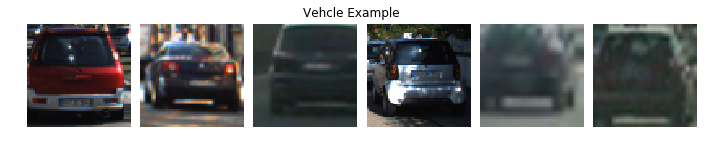

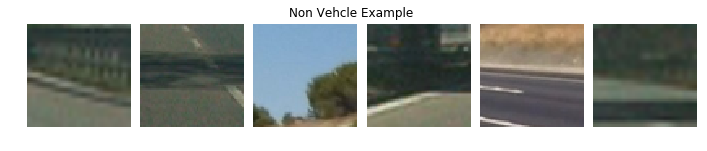

In [4]:
vehicle_example = np.random.choice(vehicle_training_file, 6)
vehicle_example_img = []
for example in vehicle_example:
    vehicle_example_img.append(mpimg.imread(example))

grid_space = gridspec.GridSpec(1, 6)
grid_space.update(wspace=0.1, hspace=0.1)
plt.figure(figsize=(12, 2))

for index in range(0, 6):
    axis = plt.subplot(grid_space[index])
    axis.axis('off')
    axis.imshow(vehicle_example_img[index])
plt.suptitle('Vehcle Example')

non_vehicle_example = np.random.choice(non_vehicle_training_file, 6)
non_vehicle_example_img = []
for example in non_vehicle_example:
    non_vehicle_example_img.append(mpimg.imread(example))

grid_space = gridspec.GridSpec(1, 6)
grid_space.update(wspace=0.1, hspace=0.1)
plt.figure(figsize=(12, 2))

for index in range(0, 6):
    axis = plt.subplot(grid_space[index])
    axis.axis('off')
    axis.imshow(non_vehicle_example_img[index])
plt.suptitle('Non Vehcle Example')

## Histogram of Oriented Gradients (HOG)

In [5]:
def generate_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False):
    if vis:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, \
                                  visualise=True, feature_vector=False)
        return features.ravel(), hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), \
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, \
                       visualise=False, feature_vector=feature_vec)
        return features.ravel()

### Example

Text(0.5,0.98,'Non Vehicle Images HOG Features')

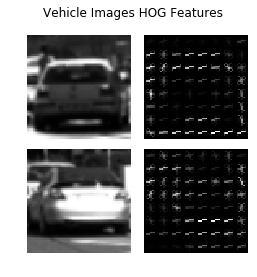

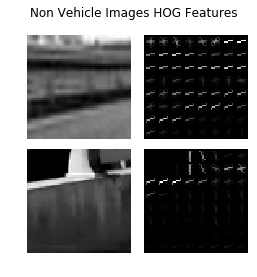

In [6]:
vehicles = []
vehicles_hog_features = []

for i in range(2):
    index = np.random.randint(1, len(vehicle_training_file))
    image = mpimg.imread(vehicle_training_file[index])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    features, hog_image = generate_hog_features(gray)
    vehicles.append(hog_image)
    vehicles_hog_features.append(gray)

space = gridspec.GridSpec(2, 2)
space.update(wspace=0.1, hspace=0.1)
plt.figure(figsize=(4, 4))

for index in range(0, 4):
    if index % 2 == 0:
        axis_1 = plt.subplot(space[index])
        axis_1.axis('off')
        axis_1.imshow(vehicles_hog_features[index // 2], cmap='gray')
    else:
        axis_2 = plt.subplot(space[index])
        axis_2.axis('off')
        axis_2.imshow(vehicles[index // 2], cmap='gray')

plt.suptitle('Vehicle Images HOG Features')

non_vehicles = []
non_vehicles_hog_features = []

for i in range(2):
    index = np.random.randint(1, len(non_vehicle_training_file))
    image = mpimg.imread(non_vehicle_training_file[index])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    features, hog_image = generate_hog_features(gray)
    non_vehicles.append(hog_image)
    non_vehicles_hog_features.append(gray)

space = gridspec.GridSpec(2, 2)
space.update(wspace=0.1, hspace=0.1)
plt.figure(figsize=(4, 4))

for index in range(0, 4):
    if index % 2 == 0:
        axis_1 = plt.subplot(space[index])
        axis_1.axis('off')
        axis_1.imshow(non_vehicles_hog_features[index // 2], cmap='gray')
    else:
        axis_2 = plt.subplot(space[index])
        axis_2.axis('off')
        axis_2.imshow(non_vehicles[index // 2], cmap='gray')

plt.suptitle('Non Vehicle Images HOG Features')

## Traning

In [7]:
def extract_features(images, cspace='RGB', orient=9, spatial_size=(32, 32), hist_bins=32,
                     pix_per_cell=8, cell_per_block=2,
                     spatial_feat=True, hist_feat=True, hog_feat=True, hog_channel=0):
    features = []
    # Iterate through the list of images
    for image in images:
        file_features = []
        # Read in each one by one
        # image = mpimg.imread(image)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat:
            color1 = cv2.resize(feature_image[:, :, 0], spatial_size).ravel()
            color2 = cv2.resize(feature_image[:, :, 1], spatial_size).ravel()
            color3 = cv2.resize(feature_image[:, :, 2], spatial_size).ravel()
            spatial_features = np.hstack((color1, color2, color3))
            # 4) Append features to list
            file_features.append(spatial_features)
        # 5) Compute histogram features if flag is set
        if hist_feat:
            color1 = np.histogram(feature_image[:, :, 0], bins=hist_bins)
            color2 = np.histogram(feature_image[:, :, 0], bins=hist_bins)
            color3 = np.histogram(feature_image[:, :, 0], bins=hist_bins)
            hist_features = np.concatenate((color1[0], color2[0], color3[0]))
            # 6) Append features to list
            file_features.append(hist_features)

        # Call generate_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(generate_hog_features(feature_image[:, :, channel],
                                                          orient=orient,
                                                          pix_per_cell=pix_per_cell,
                                                          cell_per_block=cell_per_block,
                                                          vis=False,
                                                          feature_vec=True))
             
            hog_features = np.ravel(hog_features)
            file_features.append(hog_features)
        else:
            hog_features = generate_hog_features(feature_image[:, :, hog_channel],
                                                 orient=orient,
                                                 pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,
                                                 vis=False,
                                                 feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)

        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return np.array(features)

### Parameters

In [8]:
#RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'YCrCb'
# HOG orientations
orient = 9
# HOG pixels per cell
pix_per_cell = 8
# HOG cells per block
cell_per_block = 2
# Can be 0, 1, 2, or "ALL"
hog_channel = 'ALL'
# Spatial binning dimensions
spatial_size = (32, 32)
# Number of histogram bins
hist_bins = 32
# Spatial features on or off
spatial_feat = True
# Histogram features on or off
hist_feat = True
# HOG features on or off
hog_feat = True

In [9]:
C_values = [0.08, 0.2, 0.4, 0.8, 1.0, 1.2, 1.4, 1.8, 2.6]
penalties = ['l2']
losses = ['hinge', 'squared_hinge']
training_accuracies = []
validation_accuracies = []
best_c = 1.0
best_penalty = 'l2'
best_loss = 'hinge'
best_accuracy = 0.0

vehicle_features = extract_features(vehicle_training_img, color_space, orient, spatial_size, hist_bins,
                                    pix_per_cell, cell_per_block, spatial_feat, hist_feat, hog_feat,
                                    hog_channel)
print('Shape of the vehicle features: {}'.format(vehicle_features.shape))

non_vehicle_features = extract_features(non_vehicle_training_img, color_space, orient, spatial_size,
                                        hist_bins, pix_per_cell, cell_per_block, spatial_feat,
                                        hist_feat, hog_feat, hog_channel)
print('Shape of the non-vehicle features: {}'.format(non_vehicle_features.shape))

X_features = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
print('Shape of the entire dataset: {}'.format(features.shape))

y_features = np.hstack((np.ones(len(vehicle_training_img)), np.zeros(len(non_vehicle_training_img))))
      

for c in C_values:
    for penalty in penalties:
        for loss in losses:
            X_train, X_test, y_train, y_test = train_test_split(X_features, y_features,
                                                                test_size=0.3, random_state=2048)
            
            scaler = StandardScaler().fit(X_train)
      
            X_train = scaler.transform(X_train)            
            X_test = scaler.transform(X_test)
            
            svc = LinearSVC(C = c, penalty = penalty, loss = loss).fit(X_train, y_train)
            accuracy = svc.score(X_test, y_test)
            print('Validation accuracy: {:.4f} with C: {}, panelty: {}, loss: {}'.format(accuracy, c, penalty, loss))
            
            if best_accuracy < accuracy:
                best_accuracy = accuracy                
                best_c = c
                best_loss = loss
                best_penalty = penalty
            
            validation_accuracies.append(accuracy)
            training_accuracies.append(svc.score(X_train, y_train))

print('Best validation accuracy: {:.4f}'.format(best_accuracy))
print('Best parameters: C: {}, penalty: {}, loss: {}'.format(best_c, best_penalty, best_loss))

print('')
print('Retaining with best hyper-parameters')

scaler = StandardScaler().fit(X_features)
X_features = scaler.transform(X_features)
svc = LinearSVC(C = best_c, penalty = best_penalty, loss = best_loss).fit(X_features, y_features)

Shape of the vehicle features: (8792, 8460)
Shape of the non-vehicle features: (8968, 8460)
Shape of the entire dataset: (1764,)
Validation accuracy: 0.9867 with C: 0.08, panelty: l2, loss: hinge
Validation accuracy: 0.9867 with C: 0.08, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9867 with C: 0.2, panelty: l2, loss: hinge
Validation accuracy: 0.9867 with C: 0.2, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9867 with C: 0.4, panelty: l2, loss: hinge
Validation accuracy: 0.9867 with C: 0.4, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9867 with C: 0.8, panelty: l2, loss: hinge
Validation accuracy: 0.9867 with C: 0.8, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9867 with C: 1.0, panelty: l2, loss: hinge
Validation accuracy: 0.9867 with C: 1.0, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9867 with C: 1.2, panelty: l2, loss: hinge
Validation accuracy: 0.9867 with C: 1.2, panelty: l2, loss: squared_hinge
Validation accuracy: 0.9867 w

## Sliding Window Search

In [118]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched
    # xspan = x_start_stop[1] - x_start_stop[0]
    # yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    # nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    # ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    # nx_windows = np.int(xspan / nx_pix_per_step) - 1
    # ny_windows = np.int(yspan / ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    # window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    # for ys in range(ny_windows):
    #     for xs in range(nx_windows):
    #     Calculate window position
    #         startx = xs * nx_pix_per_step + x_start_stop[0]
    #         endx = startx + xy_window[0]
    #         starty = ys * ny_pix_per_step + y_start_stop[0]
    #         endy = starty + xy_window[1]
    #         Append window position to list
    #         window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    window_list = []
    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    x_step = np.int(xy_window[0])
    y_step = np.int(xy_window[1])
    
    y_start = y_start_stop[0]
    while(y_start <= y_start_stop[1]):
        x_start = 0
        nx_pix_per_step = np.int(x_step * (1 - xy_overlap[0]))
        ny_pix_per_step = np.int(y_step * (1 - xy_overlap[1]))
        while(x_start <= x_start_stop[1]):
            startx = x_start
            endx = startx + x_step
            if endx > x_start_stop[1]:
                endx = x_start_stop[1]
            starty = y_start
            endy = starty + y_step
            if endy > y_start_stop[1]:
                endy = y_start_stop[1]
            window_list.append(((startx, starty), (endx, endy)))
            
            x_start = x_start + nx_pix_per_step
         
        x_start = 0
        y_start = y_start + ny_pix_per_step
        
        x_step = np.int(x_step * 2)
        y_step = np.int(y_step * 2)
        
        if x_step <= 1:
            x_step = 2
        if y_step <= 1:
            y_step = 2
                
    return window_list

### Slide Window Example

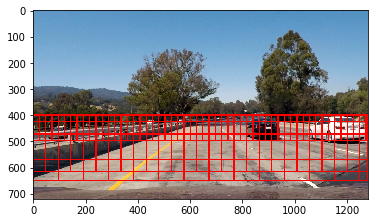

In [119]:
slide_img_example = './test_images/test1.jpg'
slide_img_example = mpimg.imread(slide_img_example)

windows = slide_window(slide_img_example, xy_window=(96, 96), xy_overlap=(0.75, 0.75), y_start_stop=[400, 650])

for window in windows:
    cv2.rectangle(slide_img_example, window[0], window[1], (255, 0, 0), 3)
plt.imshow(slide_img_example)

In [120]:
def search_windows(img, windows, clf, scaler, color_space,
                   spatial_size, hist_bins,
                   orient, pix_per_cell, cell_per_block,
                   hog_channel, spatial_feat,
                   hist_feat, hog_feat):
    hot_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        extracted_features = extract_features([test_img], cspace=color_space, orient=orient, spatial_size=spatial_size,
                                              hist_bins=hist_bins,
                                              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                              spatial_feat=spatial_feat, hist_feat=hog_feat, hog_feat=hist_feat,
                                              hog_channel=hog_channel)

        test_features = scaler.transform(np.array(extracted_features).reshape(1, -1))
        prediction = clf.predict(test_features)

        if prediction == 1:
            hot_windows.append(window)
    return hot_windows

### Example

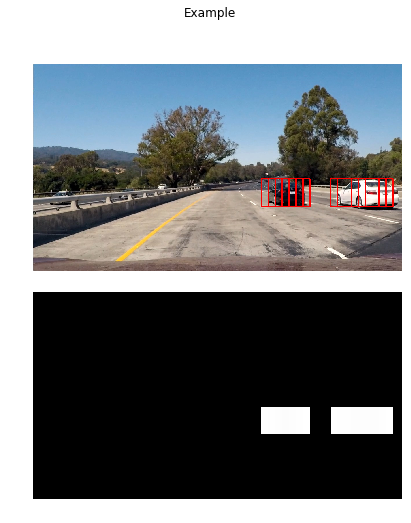

In [121]:
space = gridspec.GridSpec(2, 1)
space.update(wspace=0.1, hspace=0.1)
plt.figure(figsize=(8, 8))

plt.suptitle('Example')

for file in os.listdir('./test_images/'):
    if file.endswith('.jpg'):
        image = mpimg.imread('./test_images/' + file)
        copy_image = np.copy(image)
        draw_image = np.copy(image)
        image = image.astype(np.float32) / 255.0

        y_start_stop = [400,600]  # Min and max in y to search in sliding windows

        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                                xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    
        hot_windows = search_windows(image, windows, svc, scaler, color_space=color_space,
                                     spatial_size=spatial_size, hist_bins=hist_bins,
                                     orient=orient, pix_per_cell=pix_per_cell,
                                     cell_per_block=cell_per_block,
                                     hog_channel=hog_channel, spatial_feat=spatial_feat,
                                     hist_feat=hist_feat, hog_feat=hog_feat)

        for window in hot_windows:
            cv2.rectangle(draw_image, window[0], window[1], (255, 0, 0), 3)
        
        axis_1 = plt.subplot(space[0])
        axis_1.axis('off')
        axis_1.imshow(draw_image)

        heat_map = np.zeros_like(image)
        for window in hot_windows:
            heat_map[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
        
        axis_2 = plt.subplot(space[1])
        axis_2.axis('off')
        axis_2.imshow(heat_map, cmap='hot')

## Detect Vehicle

### Parameters

In [122]:
x_start_stop=[None, None]
y_start_stop = [400,600] 
xy_window=(96, 96)
xy_overlap=(0.75, 0.75)
heat_threshold = 1
frame_queue = []

In [123]:
def detect(image):
    global color_space
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel
    global spatial_size
    global hist_bins
    global spatial_feat
    global hist_feat
    global hog_feat
    global y_start_stop
    global x_start_stop
    global xy_window
    global xy_overlap
    global heat_threshold
    global scaler
    global svc
    global frame_queue

    copy_image = np.copy(image)
    copy_image = copy_image.astype(np.float32) / 255.0
    
    windows = slide_window(copy_image, x_start_stop,
                            y_start_stop,
                            xy_window, xy_overlap)

    hot_windows = search_windows(copy_image, windows, svc, scaler,
                                color_space, spatial_size,
                                hist_bins, orient,
                                pix_per_cell, cell_per_block,
                                hog_channel, spatial_feat,
                                hist_feat, hog_feat)

    heat_map = np.zeros_like(copy_image)
    for window in hot_windows:
        heat_map[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1

    # plt.imshow(heat_map)
            
    frame_queue.insert(0, heat_map)
    if len(frame_queue) > 10:
            frame_queue.pop()

    all_frames = np.array(frame_queue)
    all_frames = np.sum(all_frames, axis=0)
    
    all_frames[all_frames <= heat_threshold] = 0

    # plt.imshow(all_frames)
    
    labels = label(all_frames)

    for car in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(image, bbox[0], bbox[1], (255, 0, 0), 3)

    return image

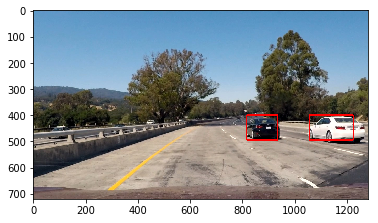

In [124]:
for file in os.listdir('./test_images/'):
    if file.endswith('.jpg'):
        image = mpimg.imread('./test_images/' + file)
        output = detect(image)

        plt.imshow(output)

## Output

In [125]:
frame_queue = []

input_video = './test_video.mp4'
output_video = './output_videos/test_video.mp4'

clip = VideoFileClip(input_video)
out_clip = clip.fl_image(detect) 
out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video.mp4
[MoviePy] Writing video ./output_videos/test_video.mp4


 97%|█████████▋| 38/39 [00:21<00:00,  1.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video.mp4 



In [126]:
frame_queue = []

input_video = './project_video.mp4'
output_video = './output_videos/project_video.mp4'

clip = VideoFileClip(input_video)
out_clip = clip.fl_image(detect) 
out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [11:10<00:00,  1.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

